In [3]:
!pip install matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-12.1.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.3 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.3 MB 953.9 kB/s eta 0:00:02
   ------------- -------------------------- 0.8/2.3 MB 1.1 MB/s eta 0:00:02
   ------------------ --------------------- 1.0/2.3 MB 1.1 MB/s eta 0:00:02
   ---------------------- ----------------- 1.3/2.3 MB 1.2 MB/s eta 0:00:01
   --------------------------- ------------ 1.6/2.3 MB 1.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 2.1/2.3 MB 1.2 MB/s eta 0:00


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import os
from pathlib import Path
import re
import sqlite3
import requests
from functools import reduce
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
stasiun_mapping = {
    'DKI1': 'Jakarta Pusat',
    'DKI2': 'Jakarta Utara',
    'DKI3': 'Jakarta Selatan',
    'DKI4': 'Jakarta Timur',
    'DKI5': 'Jakarta Barat'
}

In [6]:
# Define column mapping to match data.md convention
column_mapping = {
    'pm10': 'pm_sepuluh',
    'so2': 'sulfur_dioksida',
    'co': 'karbon_monoksida',
    'o3': 'ozon',
    'no2': 'nitrogen_dioksida',
    'critical': 'parameter_pencemar_kritis',
    'categori': 'kategori',
    'lokasi_spku': 'stasiun'
}

# Define column order to match data.md
column_order = [
    'periode_data', 'tanggal', 'stasiun', 'pm_sepuluh',
    'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida',
    'max', 'parameter_pencemar_kritis', 'kategori'
]


final_year = 2019

# Define the folder path and years to combine
ispu_folder = Path("data/ISPU")
years_to_combine = [i for i in range(2015, final_year + 1, 1)]

# List to store dataframes
dfs = []

# Load and standardize files that contain the desired years
for file_path in ispu_folder.glob("*.csv"):
    # Check if any of the desired years is in the filename
    for year in years_to_combine:
        if str(year) in file_path.name:
            df_temp = pd.read_csv(file_path)
            
            print(f"Loaded: {file_path.name}")
            print(f"  Original columns: {list(df_temp.columns)}")
            
            # Rename columns to match convention
            df_temp = df_temp.rename(columns=column_mapping)
            
            # Add missing columns with None
            for col in column_order:
                if col not in df_temp.columns:
                    df_temp[col] = None
            
            # Reorder columns to match data.md
            df_temp = df_temp[column_order]
            
            print(f"  Standardized to: {list(df_temp.columns)}")
            print(f"  Rows: {len(df_temp)}\n")
            
            dfs.append(df_temp)
            break

print(f"Total files loaded: {len(dfs)}")

# Combine all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2015-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori', 'lokasi_spku']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 365

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2016-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 1830

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2017-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'cate

In [7]:
# Replace empty strings and "---" with NULL (NaN)
df_combined = df_combined.replace(['', '---', ' ', '  '], pd.NA)
df_combined = df_combined[df_combined['kategori'] != 'TIDAK ADA DATA']

df_combined['tanggal'] = pd.to_datetime(
    df_combined['tanggal'], 
    format='mixed',  # Allows multiple formats
    dayfirst=False,  # Month comes first in ambiguous cases
    errors='raise'
)

# Convert pollutant columns to integers (pd.NA will remain as NaN for nullable Int64)
numeric_columns = ['pm_sepuluh', 'sulfur_dioksida', 
                   'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max']

for col in numeric_columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce').astype('Int64')

In [8]:
# Function to extract station ID (DKIx format)
def extract_station_id(station_name):
    if pd.isna(station_name):
        return station_name
    # Extract DKI followed by a number
    match = re.search(r'DKI\d+', str(station_name), re.IGNORECASE)
    if match:
        return match.group(0).upper()
    return station_name

# Apply normalization to stasiun column
df_combined['stasiun'] = df_combined['stasiun'].apply(extract_station_id)

In [9]:
df_combined['ID'] = df_combined['tanggal'].astype(str) + '_' + df_combined['stasiun'].astype(str)
df_combined = df_combined[['ID'] + column_order]
df_combined = df_combined.sort_values(by=['tanggal']).reset_index(drop=True)
df_combined = df_combined.ffill()
# df_combined['kota'] = 

In [10]:
df_combined.info()

<class 'pandas.DataFrame'>
RangeIndex: 4663 entries, 0 to 4662
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         4663 non-null   str           
 1   periode_data               4663 non-null   int64         
 2   tanggal                    4663 non-null   datetime64[us]
 3   stasiun                    4663 non-null   str           
 4   pm_sepuluh                 4663 non-null   Int64         
 5   sulfur_dioksida            4663 non-null   Int64         
 6   karbon_monoksida           4663 non-null   Int64         
 7   ozon                       4663 non-null   Int64         
 8   nitrogen_dioksida          4663 non-null   Int64         
 9   max                        4663 non-null   Int64         
 10  parameter_pencemar_kritis  4663 non-null   str           
 11  kategori                   4663 non-null   str           
dtypes: Int64(6), date

In [ ]:
df_combined.to_csv('data/ispu_2015-2019.csv', index=False)

In [11]:
df_combined

,ID,periode_data,tanggal,stasiun,pm_sepuluh,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,2015-01-01_DKI1,201501,2015-01-01,DKI1,49,10,39,27,10,49,PM10,BAIK
1,2015-01-02_DKI2,201501,2015-01-02,DKI2,28,9,26,48,10,48,O3,BAIK
2,2015-01-03_DKI2,201501,2015-01-03,DKI2,27,10,28,44,10,44,O3,BAIK
3,2015-01-04_DKI2,201501,2015-01-04,DKI2,22,9,28,42,12,42,O3,BAIK
4,2015-01-05_DKI2,201501,2015-01-05,DKI2,25,9,25,32,7,32,O3,BAIK
...,...,...,...,...,...,...,...,...,...,...,...,...
4658,2019-12-27_DKI4,201912,2019-12-27,DKI4,55,38,26,84,11,84,O3,SEDANG
4659,2019-12-28_DKI2,201912,2019-12-28,DKI2,64,37,34,61,11,64,PM10,SEDANG
4660,2019-12-29_DKI5,201912,2019-12-29,DKI5,64,38,36,69,10,69,O3,SEDANG
4661,2019-12-30_DKI2,201912,2019-12-30,DKI2,77,37,55,89,9,89,O3,SEDANG


# QC

In [ ]:
# Check for issues that might need cleanup
print("=== Data Quality Check ===\n")

# 1. Check for duplicate IDs
duplicates = df_combined[df_combined['ID'].duplicated(keep=False)]
print(f"Duplicate IDs: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates[['ID', 'tanggal', 'stasiun', 'kategori']].head())

# 2. Check for missing values in key columns
print("\nMissing values in critical columns:")
print(df_combined[['ID', 'tanggal', 'stasiun', 'kategori']].isnull().sum())

# 3. Check for invalid station IDs
print("\nUnique station IDs:")
print(sorted(df_combined['stasiun'].unique()))

# 4. Check kategori values
print("\nKategori distribution:")
print(df_combined['kategori'].value_counts())

# 5. Check for invalid dates
print(f"\nInvalid dates (NaT): {df_combined['tanggal'].isna().sum()}")

# 6. Check for negative or unrealistic pollutant values
print("\nNegative pollutant values:")
for col in numeric_columns:
    neg_count = (df_combined[col] < 0).sum()
    if neg_count > 0:
        print(f"  {col}: {neg_count}")

=== Data Quality Check ===

Duplicate IDs: 345
                  ID    tanggal stasiun kategori
421  2016-01-12_DKI3 2016-01-12    DKI3     BAIK
422  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
423  2016-01-12_DKI3 2016-01-12    DKI3   SEDANG
424  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
425  2016-01-12_DKI2 2016-01-12    DKI2   SEDANG

Missing values in critical columns:
ID          0
tanggal     0
stasiun     0
kategori    0
dtype: int64

Unique station IDs:
['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']

Kategori distribution:
kategori
SEDANG                2938
BAIK                   911
TIDAK SEHAT            778
SANGAT TIDAK SEHAT      36
Name: count, dtype: int64

Invalid dates (NaT): 0

Negative pollutant values:


# Data Wilayah Administrasi DKI Jakarta

In [12]:
# Load administrative region codes (optional reference)


url = "https://raw.githubusercontent.com/cahyadsn/wilayah/refs/heads/master/db/wilayah.sql"
response = requests.get(url)
response.raise_for_status()
sql_content = response.text

# Clean SQL
clean_sql = re.sub(r'^/\*.*?\*/\s*|--.*?$|ENGINE=\w+\s*|DEFAULT CHARSET=\w+\s*', '', 
                   sql_content, flags=re.DOTALL | re.MULTILINE)
clean_sql = clean_sql.replace('`', '').strip()

# Load to SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS wilayah (kode TEXT PRIMARY KEY, nama TEXT)")

statements = [s.strip() for s in clean_sql.split(';') if s.strip() and 'INSERT INTO' in s.upper()]
for stmt in statements[:5000]:  # Limit for efficiency
    try:
        cursor.execute(stmt)
    except:
        pass

conn.commit()
df_wilayah = pd.read_sql_query("SELECT * FROM wilayah WHERE kode LIKE '31%'", conn)
print(f"Loaded {len(df_wilayah)} DKI Jakarta administrative codes")

Loaded 318 DKI Jakarta administrative codes


# Data Kualitas Air Sungai

In [13]:
sungai = pd.read_csv('data/kualitas-air-sungai/data-kualitas-air-sungai-komponen-data.csv')

In [14]:
params_sungai = ['Kimia', 'Fisika', 'Biologi'] 

index_columns = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel',
       'nama_sungai', 'alamat', 'latitude', 'longitude']
parameter_columns = 'parameter'
value_columns = 'hasil_pengukuran'

In [15]:
sungai_dfs = []
for param in params_sungai:
    _sungai_df = sungai[sungai['jenis_parameter'] == param].sort_values(by=['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel'])
    _sungai_df = _sungai_df.pivot(index=index_columns, columns=parameter_columns, values=value_columns)
    # _sungai_df.columns = [f'{val}_{par}' for val, par in _sungai_df.columns]
    _sungai_df = _sungai_df.reset_index()
    print(len(_sungai_df))
    sungai_dfs.append(_sungai_df)

480
480
480


In [23]:
common_cols = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude']

sungai_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols, how='inner'), sungai_dfs)
sungai_df.columns.name = None

In [22]:
sungai_df

,periode_data,periode_pemantauan,bulan_sampling,titik_sampel,nama_sungai,alamat,latitude,longitude,Amoniak,BOD,...,Sulfat,Total N,Total P,Zn,pH,TDS,TSS,Warna,Fecal Coliform,Total Coliform
0,2024,Periode 1,2,ANK 1,Angke,Jl. Duri Kosambi Ciledug,-6.175882,106.728695,2.558,5.40,...,23.22,7.559,0.474,0.011,6.7648,208.0,70.0,7.0,16000.0,16000.0
1,2024,Periode 1,2,ANK 2,Angke,Jl. Daan Mogot Pesing,-6.158863,106.763746,3.330,7.00,...,17.46,9.030,0.624,0.027,6.7518,392.0,21.0,8.0,1700.0,1700.0
2,2024,Periode 1,2,ANK 3,Angke,Jl. Tubagus Angke,-6.157758,106.767695,3.082,6.90,...,11.31,8.778,0.595,0.012,6.7562,358.0,26.0,9.0,17000.0,17000.0
3,2024,Periode 1,2,BLC 1,Blencong,Jl. Rorotan Marunda,-6.118484,106.956440,4.786,7.00,...,25.74,9.021,1.190,0.019,8.4571,744.0,25.0,3.0,1600001.0,1600001.0
4,2024,Periode 1,2,BRN 1,Buaran,Jl. Kalimalang Depo Bangunan Pondok Kelapa,-6.246067,106.920545,4.894,5.90,...,13.54,6.509,0.839,0.008,6.0204,338.0,9.0,5.0,430000.0,1600001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2024,Periode 4,10,STR 7,Sunter,Jl. Yos Sodarso Kodamar,-6.155556,106.886139,18.950,32.51,...,25.90,27.480,1.990,0.009,7.4450,364.5,58.0,73.0,14000000.0,28000000.0
476,2024,Periode 4,10,STR 8,Sunter,Bogasari Koja,-6.118972,106.896250,15.100,44.99,...,56.10,18.210,1.450,0.009,7.4500,2056.0,45.0,68.0,2200000.0,3000000.0
477,2024,Periode 4,10,TRB 1,Tarum Barat,Jl. Kalimalang Batas DKI Jakarta Ruko Caman,-6.249899,106.952948,0.350,11.55,...,29.30,1.310,2.300,0.020,7.2150,151.4,27.0,5.0,3500.0,9000.0
478,2024,Periode 4,10,TRB 2,Tarum Barat,Jl. Kalimalang Universitas Borobudur,-6.242500,106.897076,0.280,10.74,...,24.40,1.220,2.300,0.010,7.2800,150.7,29.0,6.0,2200.0,5000.0


# Data Batas Wilayah Administrasi DKI Jakarta

In [51]:
# Helper Functions
import json
from shapely.geometry import Polygon, MultiPolygon

def parse_boundary_sql(sql_content):
    """Parse SQL file to extract boundary data."""
    lines = sql_content.split('\n')
    data = []
    
    for line in lines:
        line = line.strip()
        if line.startswith("('"):
            try:
                first_quote = line.find("'")
                second_quote = line.find("'", first_quote + 1)
                kode = line[first_quote+1:second_quote]
                
                third_quote = line.find("'", second_quote + 1)
                fourth_quote = line.find("'", third_quote + 1)
                nama = line[third_quote+1:fourth_quote]
                
                after_nama = line[fourth_quote+2:]
                parts = after_nama.split(',', 2)
                
                if len(parts) >= 3:
                    lat = parts[0].strip()
                    lng = parts[1].strip()
                    rest = parts[2]
                    path_start = rest.find("'")
                    path_end = rest.rfind("'")
                    if path_start != -1 and path_end != -1:
                        geom = rest[path_start+1:path_end]
                        data.append([kode, nama, lat, lng, geom])
            except:
                pass
    
    return pd.DataFrame(data, columns=['kode', 'nama', 'lat', 'lng', 'geom'])

def swap_coords(coord_list):
    """Recursively swap [lat,lng] to [lng,lat] for GeoJSON compatibility."""
    if isinstance(coord_list[0], (int, float)):
        return [coord_list[1], coord_list[0]]
    else:
        return [swap_coords(c) for c in coord_list]

def parse_geometry(geom_str):
    """Parse geometry string to Shapely Polygon/MultiPolygon."""
    try:
        coords = json.loads(geom_str)
        coords = swap_coords(coords)
        
        if isinstance(coords[0][0], (int, float)):
            return Polygon(coords)
        elif isinstance(coords[0][0][0], (int, float)):
            exterior = coords[0]
            holes = coords[1:] if len(coords) > 1 else []
            return Polygon(exterior, holes)
        else:
            polygons = []
            for poly_coords in coords:
                exterior = poly_coords[0]
                holes = poly_coords[1:] if len(poly_coords) > 1 else []
                polygons.append(Polygon(exterior, holes))
            return MultiPolygon(polygons)
    except Exception as e:
        print(f"Error parsing geometry: {e}")
        return None

def assign_to_nearest_region(gdf_points, gdf_boundaries, nama_col='kota_kabupaten'):
    """Assign unassigned points to nearest boundary with tie-breaking by current count."""
    unassigned_mask = gdf_points[nama_col].isna()
    unassigned_indices = gdf_points[unassigned_mask].index
    
    if len(unassigned_indices) == 0:
        return gdf_points
    
    print(f"Assigning {len(unassigned_indices)} samples to nearest boundaries...")
    current_counts = gdf_points[nama_col].value_counts().to_dict()
    
    for idx in unassigned_indices:
        point = gdf_points.loc[idx, 'geometry']
        distances = []
        
        for _, boundary_row in gdf_boundaries.iterrows():
            dist = point.distance(boundary_row['geometry'])
            nama = boundary_row['nama']
            count = current_counts.get(nama, 0)
            distances.append((dist, count, nama))
        
        distances.sort(key=lambda x: (x[0], x[1]))
        _, _, nearest_nama = distances[0]
        
        gdf_points.loc[idx, nama_col] = nearest_nama
        current_counts[nearest_nama] = current_counts.get(nearest_nama, 0) + 1
    
    return gdf_points

In [25]:
# ────────────────────────────────────────────────
# Step 1: Download the SQL file content
# ────────────────────────────────────────────────
url = "https://raw.githubusercontent.com/cahyadsn/wilayah_boundaries/refs/heads/main/db/kab/wilayah_boundaries_kab_31.sql"
response = requests.get(url)
response.raise_for_status()          # fail early if download error
sql_content = response.text

# Clean the SQL content
clean_sql = re.sub(r'^/\*.*?\*/\s*', '', sql_content, flags=re.DOTALL | re.MULTILINE).strip()

# Additional cleaning
clean_sql = re.sub(r'--.*?$', '', clean_sql, flags=re.MULTILINE)  # Remove -- comments
clean_sql = re.sub(r'ENGINE=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove ENGINE
clean_sql = re.sub(r'DEFAULT CHARSET=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove CHARSET
clean_sql = clean_sql.replace('`', '')  # Remove backticks

In [26]:
# Parse boundary data
df_batas_wilayah = parse_boundary_sql(clean_sql)

# Filter out Kepulauan Seribu (only keep mainland Jakarta)
df_batas_wilayah = df_batas_wilayah[df_batas_wilayah['kode'] != '31.01'].reset_index(drop=True)

print(f"Loaded {len(df_batas_wilayah)} mainland DKI Jakarta boundaries:")
print(df_batas_wilayah[['kode', 'nama']].to_string(index=False))

Loaded 5 mainland DKI Jakarta boundaries:
 kode                              nama
31.71   Kota Administrasi Jakarta Pusat
31.72   Kota Administrasi Jakarta Utara
31.73   Kota Administrasi Jakarta Barat
31.74 Kota Administrasi Jakarta Selatan
31.75   Kota Administrasi Jakarta Timur


In [27]:
# Convert to GeoDataFrame
df_batas_wilayah['geometry'] = df_batas_wilayah['geom'].apply(parse_geometry)

gdf_boundaries = gpd.GeoDataFrame(
    df_batas_wilayah[df_batas_wilayah['geometry'].notna()], 
    geometry='geometry', 
    crs='EPSG:4326'
)

print(f"Created GeoDataFrame with {len(gdf_boundaries)} boundaries")
print(f"Bounds: {gdf_boundaries.total_bounds}")

Created GeoDataFrame with 5 boundaries
Bounds: [106.68580472  -6.37251297 106.97300406  -6.07431556]


In [67]:
# Spatial join: Assign river samples to kota/kabupaten
gdf_sungai = gpd.GeoDataFrame(
    sungai_df,
    geometry=gpd.points_from_xy(sungai_df.longitude, sungai_df.latitude),
    crs='EPSG:4326'
)

gdf_sungai_with_region = gpd.sjoin(
    gdf_sungai, 
    gdf_boundaries[['nama', 'geometry']], 
    how='left', 
    predicate='within'
)

gdf_sungai_with_region = gdf_sungai_with_region.rename(columns={'nama': 'kota_kabupaten'})

In [68]:
if 'index_right' in gdf_sungai_with_region.columns:
    gdf_sungai_with_region = gdf_sungai_with_region.drop(columns=['index_right'])

# Assign unassigned samples to nearest boundary
gdf_sungai_with_region = assign_to_nearest_region(gdf_sungai_with_region, gdf_boundaries)

# Convert to regular DataFrame
sungai_df_with_region = pd.DataFrame(gdf_sungai_with_region.drop(columns=['geometry']))
sungai_df_with_region['kota_kabupaten'] = sungai_df_with_region['kota_kabupaten'].str.replace('Kota Administrasi ', '')

print(f"\n✓ All {len(sungai_df_with_region)} samples assigned to mainland DKI Jakarta regions")
print("\nDistribution:")
print(sungai_df_with_region['kota_kabupaten'].value_counts().to_string())

Assigning 24 samples to nearest boundaries...

✓ All 480 samples assigned to mainland DKI Jakarta regions

Distribution:
kota_kabupaten
Jakarta Timur      156
Jakarta Selatan    108
Jakarta Barat       96
Jakarta Utara       64
Jakarta Pusat       56


In [69]:
def add_stasiun_column(df, stasiun_mapping):
    """
    Add 'stasiun' column to dataframe based on kota_kabupaten mapping.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'kota_kabupaten' column
    stasiun_mapping : dict
        Dictionary mapping stasiun codes to region names
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added 'stasiun' column
    """
    # Create reverse mapping (region name -> station code)
    reverse_mapping = {v: k for k, v in stasiun_mapping.items()}
    
    # Map kota_kabupaten to stasiun
    df['stasiun'] = df['kota_kabupaten'].map(reverse_mapping)
    
    # Report unmapped regions
    unmapped = df[df['stasiun'].isna()]['kota_kabupaten'].unique()
    if len(unmapped) > 0:
        print(f"Warning: {len(unmapped)} regions could not be mapped:")
        print(unmapped)
    
    return df

# Apply the function
sungai_df_with_region = add_stasiun_column(sungai_df_with_region, stasiun_mapping)

print("\nStasiun distribution:")
print(sungai_df_with_region['stasiun'].value_counts().to_string())


Stasiun distribution:
stasiun
DKI4    156
DKI3    108
DKI5     96
DKI2     64
DKI1     56


In [70]:
sungai_df_with_region = sungai_df_with_region.sort_values(by=['bulan_sampling', 'stasiun']).reset_index(drop=True)
sungai_df_with_region = sungai_df_with_region.drop(columns = ['periode_pemantauan', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude'])
sungai_df_with_region

,periode_data,bulan_sampling,Amoniak,BOD,COD,Cd,Cr6,Cu,DO,F,...,Total P,Zn,pH,TDS,TSS,Warna,Fecal Coliform,Total Coliform,kota_kabupaten,stasiun
0,2024,2,5.009,10.50,89.09,0.001,0.0030,0.004,1.1542,0.597,...,1.034,0.020,7.7035,396.0,65.0,10.0,1600001.0,1600001.0,Jakarta Pusat,DKI1
1,2024,2,3.895,5.70,42.82,0.001,0.0009,0.004,1.8028,0.958,...,0.642,0.006,6.8381,312.0,10.0,0.9,1600000.0,1600000.0,Jakarta Pusat,DKI1
2,2024,2,0.398,7.40,57.32,0.001,0.0009,0.004,2.8908,0.437,...,0.543,0.004,6.7456,168.0,257.0,6.0,160000.0,160000.0,Jakarta Pusat,DKI1
3,2024,2,0.496,6.50,49.72,0.001,0.0020,0.004,2.5739,0.070,...,0.582,0.012,6.1184,172.0,288.0,4.0,350000.0,350000.0,Jakarta Pusat,DKI1
4,2024,2,0.810,6.30,48.34,0.001,0.0050,0.004,2.1777,0.283,...,0.556,0.014,6.6231,148.0,230.0,3.0,1600000.0,1600000.0,Jakarta Pusat,DKI1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2024,10,17.450,14.05,77.00,0.004,0.0130,0.009,0.4200,0.110,...,1.900,0.010,7.6550,338.3,59.0,50.0,3000000.0,9000000.0,Jakarta Barat,DKI5
476,2024,10,17.550,39.25,182.00,0.004,0.0270,0.009,0.2300,0.110,...,1.750,0.009,7.5750,372.7,40.0,54.0,3000000.0,9000000.0,Jakarta Barat,DKI5
477,2024,10,4.100,10.84,64.00,0.004,0.0070,0.009,1.8100,0.110,...,1.350,0.009,7.5850,281.1,24.0,35.0,1700000.0,2400000.0,Jakarta Barat,DKI5
478,2024,10,22.950,47.95,252.00,0.004,0.1030,0.009,0.9500,0.110,...,1.920,0.010,7.4700,407.9,52.0,53.0,11000000.0,24000000.0,Jakarta Barat,DKI5


In [72]:
sungai_df_with_region[['bulan_sampling', 'stasiun']].value_counts()

bulan_sampling  stasiun
2               DKI4       39
5               DKI4       39
8               DKI4       39
10              DKI4       39
2               DKI3       27
5               DKI3       27
8               DKI3       27
10              DKI3       27
2               DKI5       24
5               DKI5       24
8               DKI5       24
10              DKI5       24
2               DKI2       16
5               DKI2       16
8               DKI2       16
10              DKI2       16
2               DKI1       14
5               DKI1       14
8               DKI1       14
10              DKI1       14
Name: count, dtype: int64

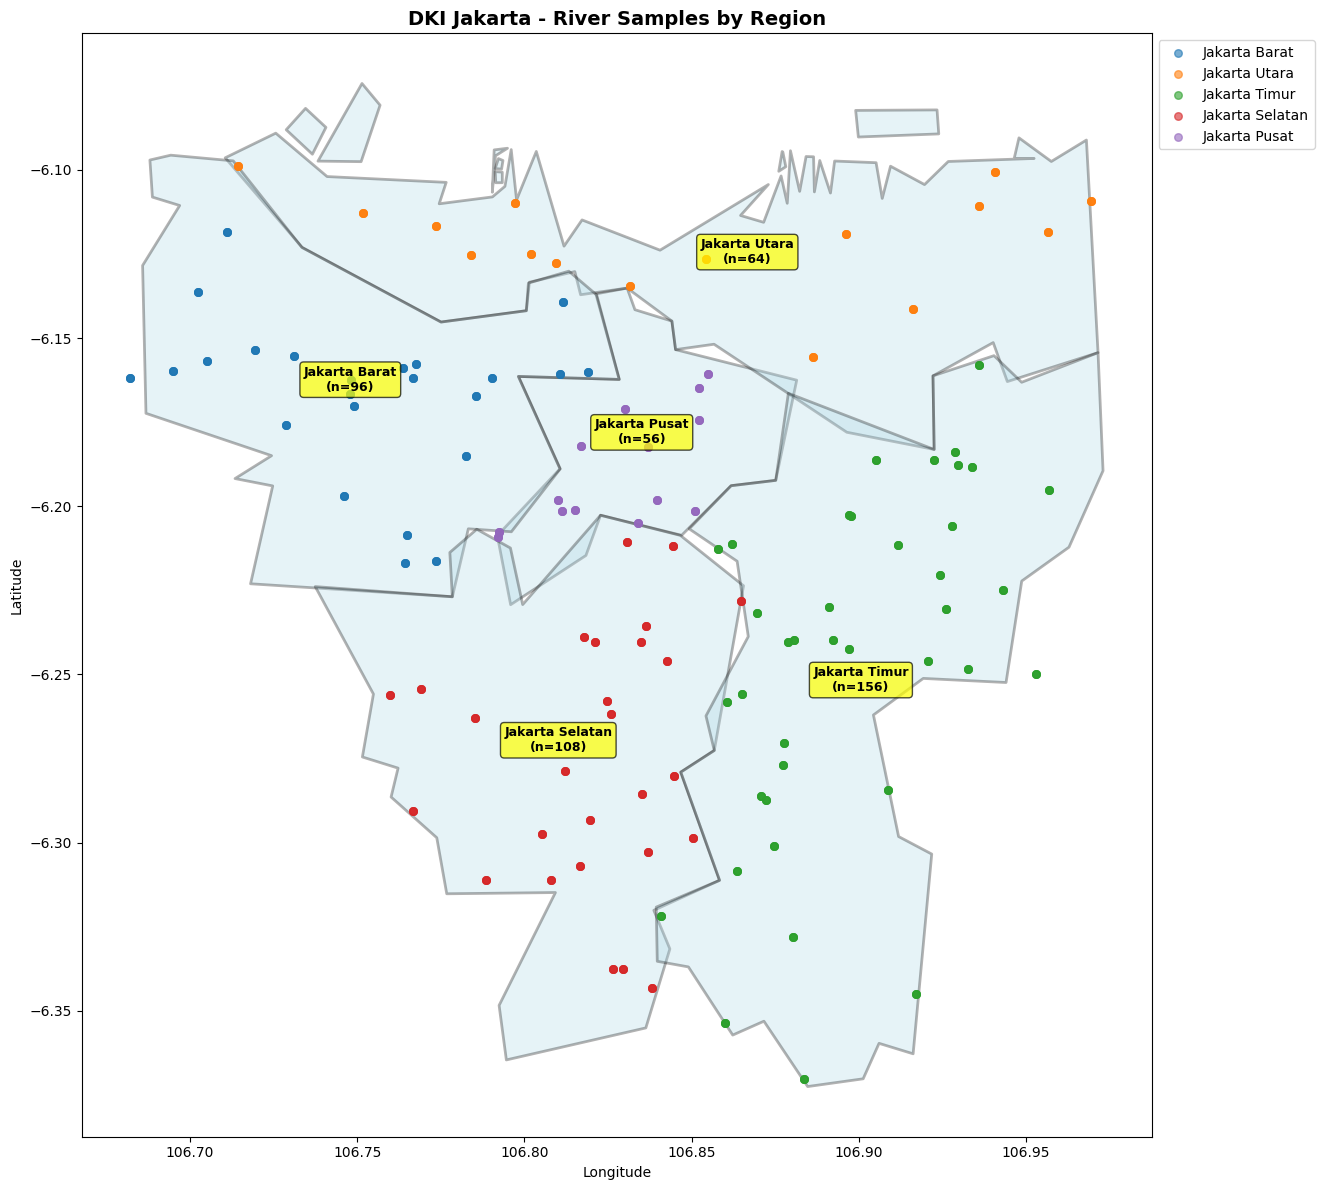

In [29]:
# Visualize regional assignments
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
gdf_boundaries.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.3, linewidth=2, aspect=None)

# Plot samples colored by region
for kota in gdf_sungai_with_region['kota_kabupaten'].unique():
    samples = gdf_sungai_with_region[gdf_sungai_with_region['kota_kabupaten'] == kota]
    samples.plot(ax=ax, markersize=30, alpha=0.6, label=kota.replace('Kota Administrasi ', ''))

# Add labels to boundaries
for _, row in gdf_boundaries.iterrows():
    centroid = row.geometry.centroid
    short_name = row['nama'].replace('Kota Administrasi ', '')
    count = (gdf_sungai_with_region['kota_kabupaten'] == row['nama']).sum()
    ax.annotate(text=f"{short_name}\n(n={count})", xy=(centroid.x, centroid.y), 
                ha='center', fontsize=9, weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
ax.set_title('DKI Jakarta - River Samples by Region', fontsize=14, weight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [34]:
sungai_df_with_region

,periode_data,periode_pemantauan,bulan_sampling,titik_sampel,nama_sungai,alamat,latitude,longitude,Amoniak,BOD,...,Total P,Zn,pH,TDS,TSS,Warna,Fecal Coliform,Total Coliform,kode,kota_kabupaten
0,2024,Periode 1,2,ANK 1,Angke,Jl. Duri Kosambi Ciledug,-6.175882,106.728695,2.558,5.40,...,0.474,0.011,6.7648,208.0,70.0,7.0,16000.0,16000.0,31.73,Jakarta Barat
1,2024,Periode 1,2,ANK 2,Angke,Jl. Daan Mogot Pesing,-6.158863,106.763746,3.330,7.00,...,0.624,0.027,6.7518,392.0,21.0,8.0,1700.0,1700.0,31.73,Jakarta Barat
2,2024,Periode 1,2,ANK 3,Angke,Jl. Tubagus Angke,-6.157758,106.767695,3.082,6.90,...,0.595,0.012,6.7562,358.0,26.0,9.0,17000.0,17000.0,31.73,Jakarta Barat
3,2024,Periode 1,2,BLC 1,Blencong,Jl. Rorotan Marunda,-6.118484,106.956440,4.786,7.00,...,1.190,0.019,8.4571,744.0,25.0,3.0,1600001.0,1600001.0,31.72,Jakarta Utara
4,2024,Periode 1,2,BRN 1,Buaran,Jl. Kalimalang Depo Bangunan Pondok Kelapa,-6.246067,106.920545,4.894,5.90,...,0.839,0.008,6.0204,338.0,9.0,5.0,430000.0,1600001.0,31.75,Jakarta Timur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2024,Periode 4,10,STR 7,Sunter,Jl. Yos Sodarso Kodamar,-6.155556,106.886139,18.950,32.51,...,1.990,0.009,7.4450,364.5,58.0,73.0,14000000.0,28000000.0,31.72,Jakarta Utara
476,2024,Periode 4,10,STR 8,Sunter,Bogasari Koja,-6.118972,106.896250,15.100,44.99,...,1.450,0.009,7.4500,2056.0,45.0,68.0,2200000.0,3000000.0,31.72,Jakarta Utara
477,2024,Periode 4,10,TRB 1,Tarum Barat,Jl. Kalimalang Batas DKI Jakarta Ruko Caman,-6.249899,106.952948,0.350,11.55,...,2.300,0.020,7.2150,151.4,27.0,5.0,3500.0,9000.0,NaN,Jakarta Timur
478,2024,Periode 4,10,TRB 2,Tarum Barat,Jl. Kalimalang Universitas Borobudur,-6.242500,106.897076,0.280,10.74,...,2.300,0.010,7.2800,150.7,29.0,6.0,2200.0,5000.0,31.75,Jakarta Timur
